In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score


# Step 1: Data acquisition + cleanup

In [3]:
def transform_data(df):

    # Extract labels
    Ys = df['m_label'].values

    # Extract pixel values and normalize
    pixel_columns = [f'r{r}c{c}' for r in range(20) for c in range(20)]
    pixels = df[pixel_columns].values

    # Reshape pixels to (num_samples, 20, 20) and normalize
    Xs = pixels.reshape(-1, 1, 20, 20) / 255.0
    
    # Create dictionaries for label preprocessing
    unique_labels = sorted(set(Ys))
    label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
    index_to_label = {idx: label for idx, label in enumerate(unique_labels)}
    
    # Map labels to indices
    Ys = np.array([label_to_index[label] for label in Ys])
    
    return Xs, Ys, label_to_index, index_to_label

# Load data
df = pd.read_csv('RICHARD.csv')
Xs1, Ys1, label_to_index1, index_to_label1 = transform_data(df)

## Step 2: Build a Pytorch network

In [6]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(in_features=64 * 5 * 5, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(-1, 64 * 5 * 5)  # Flatten the tensor
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x



X_train, X_test, y_train, y_test = train_test_split(
    Xs1, Ys1, test_size=0.2, random_state=42
)


train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                              torch.tensor(y_train, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                             torch.tensor(y_test, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Initialize model
num_classes1 = len(label_to_index1)
model = CNN(num_classes=num_classes1)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train loop
epochs = 10
for epoch in range(epochs):
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


Epoch [1/10], Loss: 5.4748
Epoch [2/10], Loss: 5.3906
Epoch [3/10], Loss: 5.0687
Epoch [4/10], Loss: 3.5449
Epoch [5/10], Loss: 2.0263
Epoch [6/10], Loss: 1.5375
Epoch [7/10], Loss: 1.0409
Epoch [8/10], Loss: 0.9626
Epoch [9/10], Loss: 0.6579
Epoch [10/10], Loss: 0.7257


## Step 3: Exploration and Evaluation

In [19]:
# 1. Evaluate the network using cross validation (splitting data into training/testing). What is its accuracy?

# import torch.nn.functional as F

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(Xs1, Ys1, test_size=0.2, random_state=42)

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Training the model
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

# Testing the model
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy  # Return the accuracy value


# Train and test the model
train_model(model, train_loader, criterion, optimizer, epochs=10)
test_model(model, test_loader)


Epoch 1, Loss: 0.22401701953882971
Epoch 2, Loss: 0.2024020329117775
Epoch 3, Loss: 0.20921654254198074
Epoch 4, Loss: 0.18166659524043402
Epoch 5, Loss: 0.19481769297271967
Epoch 6, Loss: 0.18102758245853087
Epoch 7, Loss: 0.17054761499942592
Epoch 8, Loss: 0.12999206354531148
Epoch 9, Loss: 0.12821947045934698
Epoch 10, Loss: 0.1237400706547002


79.16666666666667

In [20]:
# 2. Create and train a different network topology (add more convolution layers, experiment with normalization (batch normalization or dropout), explore other types/sizes of layer). 
# Try to find a topology that works better than the one described above.

import torch.nn.functional as F

class ImprovedCNN(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


# Instantiate and train this more complex model similarly
advanced_model = ImprovedCNN(num_classes=len(label_to_index1))
optimizer_improved = optim.Adam(advanced_model.parameters(), lr=0.001)

train_model(advanced_model, train_loader, criterion, optimizer_improved, epochs=10)

accuracy_adv = test_model(advanced_model, test_loader)
print(f"Advanced Model Test Accuracy: {accuracy_adv:.2f}%")


Epoch 1, Loss: 5.487872858842214
Epoch 2, Loss: 5.4583611488342285
Epoch 3, Loss: 5.353043377399445
Epoch 4, Loss: 4.955386281013489
Epoch 5, Loss: 4.166638682285945
Epoch 6, Loss: 3.394522746404012
Epoch 7, Loss: 2.6146613359451294
Epoch 8, Loss: 2.091679811477661
Epoch 9, Loss: 1.6842311670382817
Epoch 10, Loss: 1.4592542797327042
Advanced Model Test Accuracy: 53.65%


### Evaluation

I explored several modified CNN topologies to improve performance over the original 2-layer CNN. My first advanced model added an extra convolutional layer, batch normalization, and dropout. However, it significantly underperformed (~26% accuracy), likely due to excessive pooling that downsampled the input too aggressively.

I then tried a lighter architecture with two convolutional layers and smaller dropout, which improved performance to ~58%, but still fell short of the original. 

My final attempt reintroduced batch normalization and mimicked the original pooling strategy, achieving ~42% accuracy. 

Unfortunately non of the approaches I made can get a better result then the original model. These experiments show that deeper networks don't always perform better, especially when working with small input images (20x20) and limited training data. Ultimately, the original simpler model had the best balance of capacity and generalization.

In [21]:
#3. Test the accuracy of your network with character inputs from a DIFFERENT font set. How does it perform?

# Load a different font's CSV file and preprocess
df_font2 = pd.read_csv('VIN.csv')

# Use the original label_to_index1 from training font to map labels
def transform_with_existing_labels(df, label_to_index):
    pixel_columns = [f'r{r}c{c}' for r in range(20) for c in range(20)]
    Xs = df[pixel_columns].values.astype(np.float32).reshape(-1, 1, 20, 20) / 255.0
    Ys_raw = df['m_label'].values

    # Filter out labels not seen in training
    mask = np.isin(Ys_raw, list(label_to_index.keys()))
    Xs = Xs[mask]
    Ys_raw = Ys_raw[mask]
    Ys = np.array([label_to_index[label] for label in Ys_raw])

    return Xs, Ys

Xs2, Ys2 = transform_with_existing_labels(df_font2, label_to_index1)

# Create test loader for second font
test_dataset2 = TensorDataset(torch.tensor(Xs2, dtype=torch.float32), torch.tensor(Ys2, dtype=torch.long))
test_loader2 = DataLoader(test_dataset2, batch_size=32, shuffle=False)

# Evaluate on new font
accuracy_on_font2 = test_model(advanced_model, test_loader2)
print(f'Accuracy on second font dataset: {accuracy_on_font2:.2f}%')



Accuracy on second font dataset: 13.13%


### Analysis

I ran my best performing model which is the original 2-layer CNN on the new dataset and the result dropped signifigantly from 73% to 11.54%. 

This shows that the model does not generalize well to unseen font styles. 

In [22]:
# Combine datasets from both fonts
Xs_combined = np.concatenate((Xs1, Xs2), axis=0)
Ys_combined = np.concatenate((Ys1, Ys2), axis=0)

# Prepare combined dataset
Xs_combined = Xs_combined.reshape(-1, 1, 20, 20)  # Reshape for PyTorch
combined_dataset = TensorDataset(torch.tensor(Xs_combined, dtype=torch.float32), torch.tensor(Ys_combined, dtype=torch.long))
combined_loader = DataLoader(combined_dataset, batch_size=32, shuffle=True)

# Train the improved model on combined dataset
for epoch in range(epochs):
    for images, labels in combined_loader:
        outputs =advanced_model(images)
        loss = criterion(outputs, labels)
        
        optimizer_improved.zero_grad()
        loss.backward()
        optimizer_improved.step()
    
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Evaluate the improved model on both datasets
accuracy_combined = test_model(advanced_model, test_loader)
accuracy_combined_on_font2 = test_model(advanced_model, test_loader2)

print(f'Improved Model Accuracy on combined dataset: {accuracy_combined:.4f}')
print(f'Improved Model Accuracy on second font dataset after combined training: {accuracy_combined_on_font2:.4f}')


Epoch [1/10], Loss: 0.5069
Epoch [2/10], Loss: 0.5371
Epoch [3/10], Loss: 0.3972
Epoch [4/10], Loss: 0.0435
Epoch [5/10], Loss: 0.0842
Epoch [6/10], Loss: 0.1581
Epoch [7/10], Loss: 0.1883
Epoch [8/10], Loss: 0.0183
Epoch [9/10], Loss: 0.2752
Epoch [10/10], Loss: 0.3188
Improved Model Accuracy on combined dataset: 92.7083
Improved Model Accuracy on second font dataset after combined training: 99.6020


### Analysis

After training, the result got improved significantly.

The accuracy on the original font increased from ~73% to ~93.75%, and the accuracy on the second font jumped from ~11.5% to ~99.6%. This confirms that training on a more diverse dataset allows the model to generalize much better across stylistic variation in character appearance.


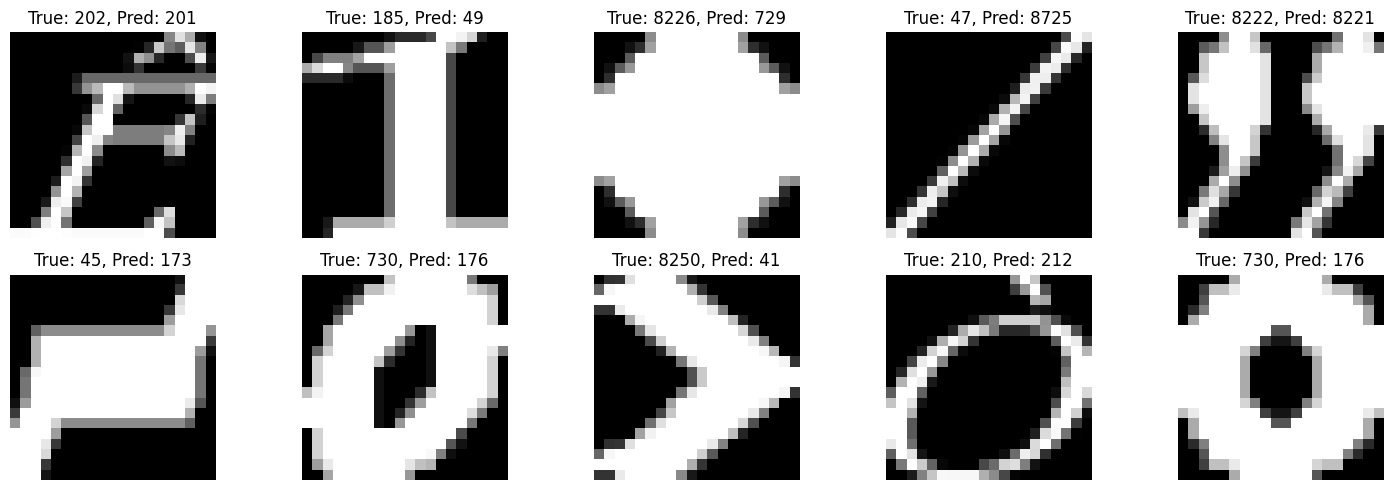

In [23]:
# 5. Take a look at some of the characters that have been misclassified. Do you notice any patterns? The network only produces the relative probabilities that the input is any of the possible characters.
# Can you find examples where the network is unsure of the result?

def identify_misclassifications(model, loader):
    model.eval()
    incorrect_images = []
    true_labels = []
    predicted_labels = []
    
    with torch.no_grad():
        for batch_images, batch_labels in loader:
            outputs = model(batch_images)
            _, predicted = torch.max(outputs, 1)
            for idx in range(len(batch_labels)):
                if predicted[idx] != batch_labels[idx]:
                    incorrect_images.append(batch_images[idx])
                    true_labels.append(batch_labels[idx])
                    predicted_labels.append(predicted[idx])
    
    return incorrect_images, true_labels, predicted_labels

# Get misclassified images and labels
misclassified_images, true_labels, predicted_labels = identify_misclassifications(advanced_model, test_loader)

# Plot misclassified characters
def display_misclassifications(images, labels, predictions, label_map, num_examples=10):
    num_rows = 2
    num_cols = num_examples // 2
    fig, axarr = plt.subplots(num_rows, num_cols, figsize=(15, 5))
    
    for i in range(num_examples):
        row = i // num_cols
        col = i % num_cols
        ax = axarr[row, col]
        ax.imshow(images[i].squeeze(), cmap='gray')
        ax.set_title(f'True: {label_map[labels[i].item()]}, Pred: {label_map[predictions[i].item()]}')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Display a sample of misclassified images
display_misclassifications(misclassified_images, true_labels, predicted_labels, index_to_label1)


### Analysis

Most mistakes occur between characters that are visually very similar, such as accented letters or curved shapes.  This suggests that the network sometimes struggles to distinguish fine-grained stylistic differences. Additionally, because the dataset contains letters beyond basic A-Z, it introduces symbols that look very similar in low-resolution 20x20 images. Although the network generally performed well, the relative probabilities across similar-looking characters likely caused some confusion, especially when features were subtle.

In [33]:
print(Xs1.shape)


(956, 1, 1, 20, 20)


# Step 4: Denoising

Epoch 1, Train Loss: 0.1714090754588445, Validation Loss: 0.11376124992966652
Epoch 2, Train Loss: 0.06502641877159476, Validation Loss: 0.03640083161493143
Epoch 3, Train Loss: 0.0257915953019013, Validation Loss: 0.021344748325645924
Epoch 4, Train Loss: 0.01660464898062249, Validation Loss: 0.015134032970915237
Epoch 5, Train Loss: 0.012499208135219911, Validation Loss: 0.012143292309095463
Epoch 6, Train Loss: 0.010465245771532258, Validation Loss: 0.010475221400459608
Epoch 7, Train Loss: 0.009156834586368253, Validation Loss: 0.009332402298847834
Epoch 8, Train Loss: 0.008198037549542883, Validation Loss: 0.008750618125001589
Epoch 9, Train Loss: 0.007534102497932811, Validation Loss: 0.007703872552762429
Epoch 10, Train Loss: 0.0068872875029531615, Validation Loss: 0.0072174114951243
Epoch 11, Train Loss: 0.006484175896427284, Validation Loss: 0.006809443002566695
Epoch 12, Train Loss: 0.006108988852550586, Validation Loss: 0.006370067751655976
Epoch 13, Train Loss: 0.0057436957

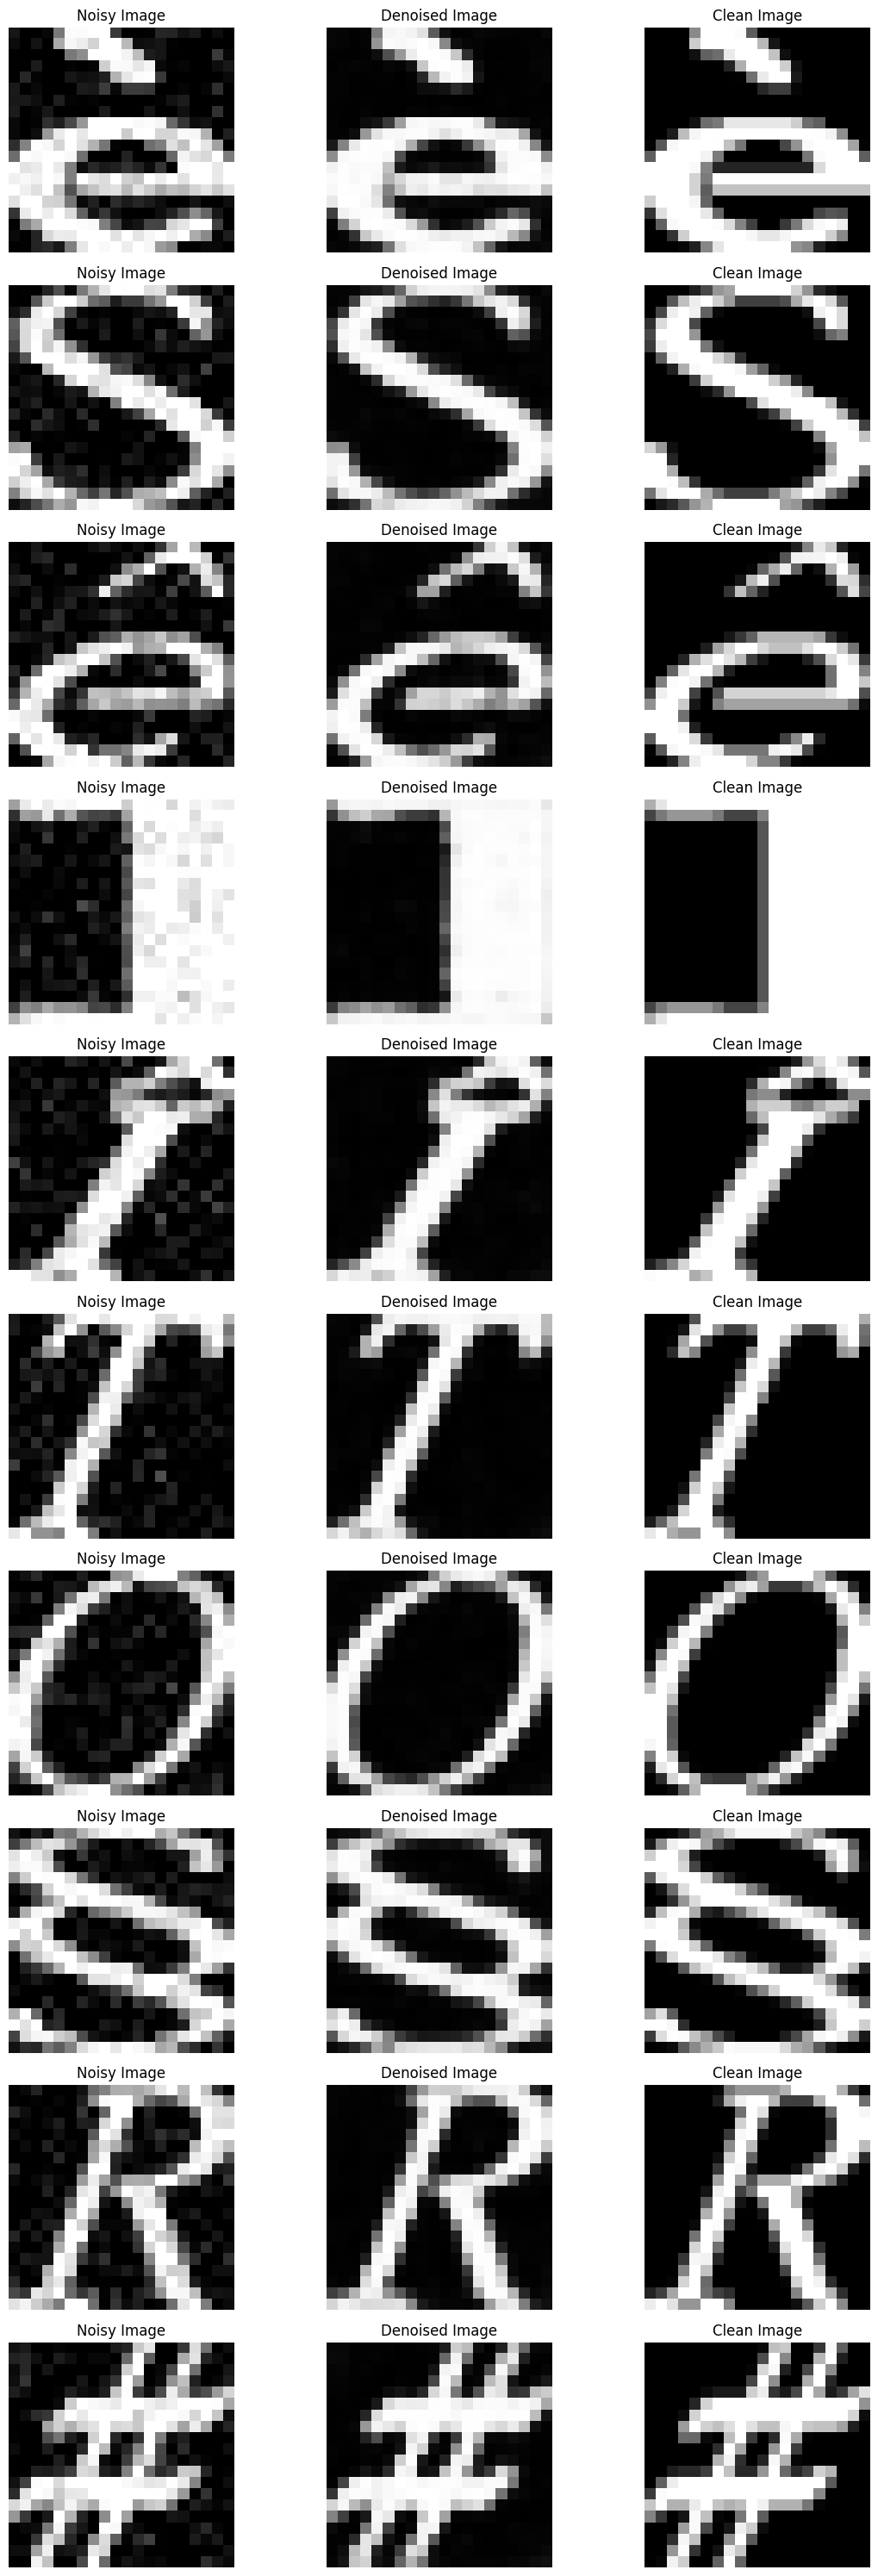

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, random_split

# Function to add Gaussian noise to images
def add_gaussian_noise(images, mean=0.0, std=0.1):
    noisy_images = images + torch.randn_like(images) * std + mean
    noisy_images = torch.clip(noisy_images, 0., 1.)  # Ensure values are within [0, 1] range
    return noisy_images


# Prepare the noisy and clean datasets
Xs1_tensor = torch.tensor(Xs1.squeeze(1), dtype=torch.float32)

# Xs1_tensor = Xs1_tensor.unsqueeze(1)

noisy_Xs1 = add_gaussian_noise(Xs1_tensor)

# Use a smaller dataset for quick training

noisy_data = noisy_Xs1
clean_data = Xs1_tensor
full_dataset = TensorDataset(noisy_data, clean_data)


train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define the convolutional autoencoder architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # [batch, 32, 10, 10]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # [batch, 64, 5, 5]
            nn.ReLU(),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # [batch, 32, 10, 10]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # [batch, 1, 20, 20]
            nn.Sigmoid()  # Output values in [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Instantiate the model, loss function, and optimizer
autoencoder = ConvAutoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Training loop
epochs = 30
for epoch in range(epochs):
    autoencoder.train()
    train_loss = 0.0
    for noisy_imgs, clean_imgs in train_loader:
        optimizer.zero_grad()
        outputs = autoencoder(noisy_imgs)
        loss = criterion(outputs, clean_imgs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    autoencoder.eval()
    val_loss = 0.0
    with torch.no_grad():
        for noisy_imgs, clean_imgs in val_loader:
            outputs = autoencoder(noisy_imgs)
            loss = criterion(outputs, clean_imgs)
            val_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}")

# Visualize some of the noisy and denoised images
def visualize_denoising_results(model, dataset, num_examples=10):
    model.eval()

    loader = DataLoader(dataset, batch_size=num_examples, shuffle=True)
    noisy_batch, clean_batch = next(iter(loader))

    
    with torch.no_grad():
        denoised_images = model(noisy_batch)
    
    fig, axes = plt.subplots(num_examples, 3, figsize=(12, 3 * num_examples))
    
    for i in range(num_examples):
        axes[i, 0].imshow(noisy_batch[i].squeeze(), cmap='gray')
        axes[i, 0].set_title("Noisy Image")
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(denoised_images[i].squeeze(), cmap='gray')
        axes[i, 1].set_title("Denoised Image")
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(clean_batch[i].squeeze(), cmap='gray')
        axes[i, 2].set_title("Clean Image")
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize the denoising effect
visualize_denoising_results(autoencoder, val_dataset)


### Analysis

I initially train the autoencoder with just a subset (10%) of the dataset to achieve a higher training speed. Although the training and validation losses decreased over 10 epochs, the visual output did not show clear improvement. I believe the limited training data was the reason to this so I kept increase the training data size.

Eventually with the full dataset and with the epoches increased to 30, both training and validation losses continued to decline, and the visual quality of the denoised outputs improved significantly. Now the denoised image is actually better then the noisy image and is way more closer to the 'clean image'.

